# Complete Workflow: Taylor Headwaters

This workflow provides a complete working example to develop an unstructured mesh for an integrated hydrologic model in the headwaters of the Taylor River.

It uses the following datasets:

* `NHD Plus` for the watershed boundary and hydrography.
* `NED` for elevation
* `NLCD` for land cover/transpiration/rooting depths
* `GLYHMPS` geology data for structural formations
* `SoilGrids 2017` for depth to bedrock and soil texture information
* `SSURGO` for soil data, where available, in the top 2m.

This workflow creates the following files:

* Mesh file: `CoalCreek.exo`, includes all labeled sets
* Forcing: DayMet data -- daily raster of precip, RH, incoming radiation, etc.
  - `CoalCreek_DayMet_1980_2020.h5`, the DayMet data on this watershed
  - `CoalCreek_DayMet_typical_1980_2020.h5`, a "typical year" of DayMet, smoothed for spinup purposes, then looped 40 years
* Forcing: LAI data -- every 4 days, time series by land cover type of LAI
  - `CoalCreek_MODIS_LAI_smoothed_2002_2020.h5`, the LAI, interpolated and smoothed from the raw MODIS data
  - `CoalCreek_MODIS_LAI_typical_1980_2020.h5`, a "typical year" of LAI, smoothed for spinup purposes then looped 40 years
* Input files: ATS xml files
  - `spinup-steadystate-CoalCreek.xml` the steady-state solution based on uniform application of mean rainfall rate
  - `spinup-cyclic_steadystate-CoalCreek.xml` the cyclic steady state based on typical years
  - `transient-CoalCreek.xml` the forward model


In [1]:
# Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed.
name = 'TaylorHeadwaters' # name the domain, used in filenames, etc
hucs = ['140200010101','140200010102','140200010103',] # a list of HUCs to run
simplify = 80 # length scale to target average edge

ignore_small_rivers = 2 # ignore rivers which have this or fewer reaches.  likely they are irrigation ditches
                        # or other small features which make things complicated but likely don't add much value
prune_by_area_fraction = 0.03 # ignore reaches whose accumulated catchment area is less than this fraction of the
                              # full domain's area
    
start_year = 1980  # year to start simulation

log_to_file = False  # if true, write to file instead of in the notebook output

In [2]:
# parameter checking
assert(simplify > 0 and simplify < 300)
assert(ignore_small_rivers == None or (ignore_small_rivers >= 0 and ignore_small_rivers <= 100))
assert(prune_by_area_fraction == None or (prune_by_area_fraction >= 0 and prune_by_area_fraction < 1))
assert(start_year >= 1980 and start_year < 2020)

In [3]:
# a dictionary of outputs -- will include all filenames generated
outputs = {}

In [4]:
# conda package imports
import os,sys
import numpy as np
import shapely
import logging
import scipy.ndimage
from matplotlib import pyplot as plt
import h5py
import pandas
pandas.options.display.max_columns = None

# Watershed Workflow
import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs
import workflow.soil_properties
import workflow.daymet

if log_to_file:
    outputs['logfile'] = f'{name}.log'
    # is this right?  the file handle will become stale... test once this is pipelined.
    with open(outputs['logfile'], 'w') as fid:
        workflow.ui.setup_logging(1,fid)
else:
    workflow.ui.setup_logging(1,None)

# ats_input_spec library, to be moved to amanzi_xml
import ats_input_spec
import ats_input_spec.public
import ats_input_spec.io

# amanzi_xml, included in AMANZI_SRC_DIR/tools/amanzi_xml
import amanzi_xml.utils.io as aio
import amanzi_xml.utils.search as asearch
import amanzi_xml.utils.errors as aerrors

# from $ATS_SRC_DIR/tools/utils
import smooth_met_box


In [5]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = workflow.crs.daymet_crs()

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [6]:
logging.info("")
logging.info(f"Meshing shape: {hucs}")
logging.info("="*30)


2021-07-26 12:54:08,943 - root - INFO: 
2021-07-26 12:54:08,944 - root - INFO: Meshing shape: ['140200010101', '140200010102', '140200010103']
2021-07-26 12:54:08,945 - root - INFO: ==============================


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [7]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
workflow.source_list.log_sources(sources)

2021-07-26 12:54:08,951 - root - INFO: Using sources:
2021-07-26 12:54:08,952 - root - INFO: --------------
2021-07-26 12:54:08,953 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-07-26 12:54:08,953 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2021-07-26 12:54:08,954 - root - INFO: DEM: National Elevation Dataset (NED)
2021-07-26 12:54:08,955 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2021-07-26 12:54:08,955 - root - INFO: geologic structure: GLHYMPS version 2.0
2021-07-26 12:54:08,956 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2021-07-26 12:54:08,956 - root - INFO: soil thickness: None
2021-07-26 12:54:08,957 - root - INFO: meteorology: DayMet 1km


In [8]:
# load the huc
my_hucs = []
for huc in hucs:
    _, ws = workflow.get_huc(sources['HUC'], huc, crs)
    my_hucs.append(ws)
    
watershed = workflow.split_hucs.SplitHUCs(my_hucs)

2021-07-26 12:54:08,965 - root - INFO: 
2021-07-26 12:54:08,966 - root - INFO: Loading HUC 140200010101
2021-07-26 12:54:08,967 - root - INFO: ------------------------------
2021-07-26 12:54:08,968 - root - INFO: 
2021-07-26 12:54:08,968 - root - INFO: Loading level 12 HUCs in 140200010101
2021-07-26 12:54:08,968 - root - INFO: ------------------------------
2021-07-26 12:54:08,970 - root - INFO: Using HUC file "/Users/uec/code/watershed_workflow/data-library/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2021-07-26 12:54:09,056 - root - INFO: ... found 1 HUCs
2021-07-26 12:54:09,056 - root - INFO:   -- 140200010101
2021-07-26 12:54:09,068 - root - INFO: Converting to out_crs
2021-07-26 12:54:09,098 - root - INFO: Converting to shapely
2021-07-26 12:54:09,100 - root - INFO: ... found 1
2021-07-26 12:54:09,101 - root - INFO: 
2021-07-26 12:54:09,102 - root - INFO: Loading HUC 140200010102
2021-07-26 12:54:09,102 - root - INFO: ------------------------------
2021-07-26 12:54:09,103 -

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

### Get river network

This will download the river network from the NHD Plus database, and simplify the network, constructing a tree-like data structure.

In [9]:
rivers = True
if rivers:
    # download/collect the river network within that shape's bounds
    _, reaches = workflow.get_reaches(sources['hydrography'], huc, 
                                      watershed.exterior().bounds, crs, crs)
    # simplify and prune rivers not IN the shape, constructing a tree-like data structure
    # for the river network
    rivers = workflow.simplify_and_prune(watershed, reaches, filter=True, simplify=simplify, 
                                         snap=False, cut_intersections=False,
                                         ignore_small_rivers=ignore_small_rivers,
                                         prune_by_area_fraction=prune_by_area_fraction)


else:
    rivers = list()
    workflow.split_hucs.simplify(watershed, simplify)
    


2021-07-26 12:54:09,345 - root - INFO: 
2021-07-26 12:54:09,346 - root - INFO: Loading Hydrography
2021-07-26 12:54:09,347 - root - INFO: ------------------------------
2021-07-26 12:54:09,347 - root - INFO: Loading streams in HUC 140200010103
2021-07-26 12:54:09,348 - root - INFO:          and/or bounds (-562803.8965103576, -365142.00558720896, -534357.7588395509, -342804.74996838305)
2021-07-26 12:54:09,349 - root - INFO:   Using Hydrography file "/Users/uec/code/watershed_workflow/data-library/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2021-07-26 12:54:09,350 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/uec/code/watershed_workflow/data-library/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb' layer 'NHDFlowline' for streams in '(-562803.8965103576, -365142.00558720896, -534357.7588395509, -342804.74996838305)'
/Users/uec/code/watershed_workflow/repos/master/workflow/sources/manager_nhd.py:171: RuntimeWarning: Sequential re

2021-07-26 12:56:01,977 - root - INFO:   ...cleaned inner segment of length 52.7567 at centroid (-540872.8315778496, -360349.9111901686)
2021-07-26 12:56:01,979 - root - INFO:   ...cleaned inner segment of length 64.6856 at centroid (-540867.4039404835, -360347.3692742472)
2021-07-26 12:56:01,980 - root - INFO:   ...cleaned inner segment of length 71.0915 at centroid (-540864.4516691185, -360346.1170077793)
2021-07-26 12:56:01,981 - root - INFO:   ...cleaned inner segment of length 6.42029 at centroid (-540819.2111790356, -360327.34067264234)
2021-07-26 12:56:01,982 - root - INFO:   ...cleaned inner segment of length 22.7389 at centroid (-540811.3962469639, -360324.95038997283)
2021-07-26 12:56:01,983 - root - INFO:   ...cleaned inner segment of length 14.8477 at centroid (-540625.608297574, -360225.7032563712)
2021-07-26 12:56:01,983 - root - INFO:   ...cleaned inner segment of length 29.1413 at centroid (-540619.1650653007, -360222.2681889235)
2021-07-26 12:56:01,984 - root - INFO:  

2021-07-26 12:56:02,052 - root - INFO:   ...cleaned inner segment of length 38.3364 at centroid (-540870.9813987135, -352931.89698532433)
2021-07-26 12:56:02,053 - root - INFO:   ...cleaned inner segment of length 56.2564 at centroid (-550030.7259364282, -354167.0470071553)
2021-07-26 12:56:02,055 - root - INFO:   ...cleaned inner segment of length 78.2716 at centroid (-550044.3299845135, -354165.4501214789)
2021-07-26 12:56:02,056 - root - INFO:   ...cleaned inner segment of length 32.1434 at centroid (-550275.8704613054, -354113.3198040534)
2021-07-26 12:56:02,058 - root - INFO:   ...cleaned inner segment of length 13.5218 at centroid (-550817.0960034211, -354102.92268218193)
2021-07-26 12:56:02,060 - root - INFO:   ...cleaned inner segment of length 23.7564 at centroid (-550821.5671076823, -354105.5258797163)
2021-07-26 12:56:02,062 - root - INFO:   ...cleaned inner segment of length 50.2049 at centroid (-550829.4321358872, -354116.53706875816)
2021-07-26 12:56:02,063 - root - INFO:

2021-07-26 12:56:02,114 - root - INFO:   ...cleaned inner segment of length 28.496 at centroid (-556613.0136043524, -354288.5461185442)
2021-07-26 12:56:02,114 - root - INFO:   ...cleaned inner segment of length 3.94592 at centroid (-553383.5986319822, -355383.2826712818)
2021-07-26 12:56:02,116 - root - INFO:   ...cleaned inner segment of length 14.3828 at centroid (-553663.1432288312, -356023.36396106146)
2021-07-26 12:56:02,117 - root - INFO:   ...cleaned inner segment of length 33.0198 at centroid (-553661.3155641056, -356032.5773963698)
2021-07-26 12:56:02,118 - root - INFO:   ...cleaned inner segment of length 44.5011 at centroid (-553661.1928648439, -356038.3346743661)
2021-07-26 12:56:02,119 - root - INFO:   ...cleaned inner segment of length 37.3501 at centroid (-553646.5074459098, -356126.4389420062)
2021-07-26 12:56:02,120 - root - INFO:   ...cleaned inner segment of length 47.1046 at centroid (-553645.8475821442, -356131.2737640599)
2021-07-26 12:56:02,121 - root - INFO:   

2021-07-26 12:56:02,169 - root - INFO:   ...cleaned inner segment of length 10.4253 at centroid (-550052.2065302914, -354767.94184706756)
2021-07-26 12:56:02,170 - root - INFO:   ...cleaned inner segment of length 19.1316 at centroid (-550054.4313977319, -354771.8536498316)
2021-07-26 12:56:02,171 - root - INFO:   ...cleaned inner segment of length 56.3223 at centroid (-550070.8258791969, -354781.3792569376)
2021-07-26 12:56:02,172 - root - INFO:   ...cleaned inner segment of length 69.1901 at centroid (-550075.866142378, -354785.38229578314)
2021-07-26 12:56:02,173 - root - INFO:   ...cleaned inner segment of length 73.1536 at centroid (-550076.9398487463, -354787.23478912073)
2021-07-26 12:56:02,174 - root - INFO:   ...cleaned inner segment of length 28.769 at centroid (-550704.40763771, -355064.2440477935)
2021-07-26 12:56:02,175 - root - INFO:   ...cleaned inner segment of length 14.6036 at centroid (-550807.0256317635, -355127.8686614245)
2021-07-26 12:56:02,175 - root - INFO:   .

2021-07-26 12:56:02,261 - root - INFO:   ...cleaned inner segment of length 39.9633 at centroid (-557314.1847039326, -347729.23492099415)
2021-07-26 12:56:02,263 - root - INFO:   ...cleaned inner segment of length 79.8397 at centroid (-557332.9195167078, -347722.3298062843)
2021-07-26 12:56:02,265 - root - INFO:   ...cleaned inner segment of length 26.4477 at centroid (-557418.9896072551, -347688.74961313594)
2021-07-26 12:56:02,270 - root - INFO:   ...cleaned inner segment of length 61.2691 at centroid (-557430.514677065, -347673.6668335736)
2021-07-26 12:56:02,274 - root - INFO:   ...cleaned inner segment of length 24.4347 at centroid (-557472.3043987735, -347621.26362930855)
2021-07-26 12:56:02,276 - root - INFO:   ...cleaned inner segment of length 75.8706 at centroid (-554496.2109807064, -345841.5365191947)
2021-07-26 12:56:02,277 - root - INFO:   ...cleaned inner segment of length 43.5285 at centroid (-553953.3618245021, -345182.23484034307)
2021-07-26 12:56:02,278 - root - INFO:

2021-07-26 12:56:02,343 - root - INFO:   ...cleaned inner segment of length 19.1547 at centroid (-550510.40441184, -361276.57532023615)
2021-07-26 12:56:02,344 - root - INFO:   ...cleaned inner segment of length 36.3438 at centroid (-550519.0235524101, -361276.51947384543)
2021-07-26 12:56:02,346 - root - INFO:   ...cleaned inner segment of length 66.1688 at centroid (-550533.9685644174, -361277.98943005886)
2021-07-26 12:56:02,346 - root - INFO:   ...cleaned inner segment of length 79.4374 at centroid (-550540.414919304, -361273.7581294528)
2021-07-26 12:56:02,347 - root - INFO:   ...cleaned inner segment of length 8.17413 at centroid (-550614.1026766859, -361264.42373400694)
2021-07-26 12:56:02,349 - root - INFO:   ...cleaned inner segment of length 55.6062 at centroid (-550635.7822027004, -361274.1033050546)
2021-07-26 12:56:02,350 - root - INFO:   ...cleaned inner segment of length 66.7495 at centroid (-550641.1533125122, -361275.6945881067)
2021-07-26 12:56:02,351 - root - INFO:  

2021-07-26 12:56:02,411 - root - INFO:   ...cleaned inner segment of length 67.5328 at centroid (-541689.6367217789, -359126.65352419973)
2021-07-26 12:56:02,412 - root - INFO:   ...cleaned inner segment of length 73.7628 at centroid (-541688.0294996093, -359123.87975254585)
2021-07-26 12:56:02,412 - root - INFO:   ...cleaned inner segment of length 14.5659 at centroid (-541667.8175585319, -359075.7767168735)
2021-07-26 12:56:02,413 - root - INFO:   ...cleaned inner segment of length 20.606 at centroid (-541666.6846918182, -359072.96923999465)
2021-07-26 12:56:02,413 - root - INFO:   ...cleaned inner segment of length 29.9402 at centroid (-541663.5868069937, -359069.32930299174)
2021-07-26 12:56:02,414 - root - INFO:   ...cleaned inner segment of length 43.6262 at centroid (-541660.3429884168, -359063.3013193476)
2021-07-26 12:56:02,414 - root - INFO:   ...cleaned inner segment of length 55.081 at centroid (-541659.9606775655, -359057.0912103351)
2021-07-26 12:56:02,416 - root - INFO: 

2021-07-26 12:56:02,462 - root - INFO:   ...cleaned inner segment of length 70.7868 at centroid (-542980.3322900024, -357445.40780748404)
2021-07-26 12:56:02,464 - root - INFO:   ...cleaned inner segment of length 7.70817 at centroid (-542980.9183943201, -357392.67545983626)
2021-07-26 12:56:02,465 - root - INFO:   ...cleaned inner segment of length 26.7771 at centroid (-542980.80490577, -357383.1005754211)
2021-07-26 12:56:02,465 - root - INFO:   ...cleaned inner segment of length 37.349 at centroid (-542981.4375736662, -357377.79030443483)
2021-07-26 12:56:02,466 - root - INFO:   ...cleaned inner segment of length 52.6378 at centroid (-542980.9665112149, -357370.1532440647)
2021-07-26 12:56:02,467 - root - INFO:   ...cleaned inner segment of length 70.0615 at centroid (-542982.3460162792, -357361.44047752547)
2021-07-26 12:56:02,468 - root - INFO:   ...cleaned inner segment of length 21.3913 at centroid (-542992.5201541991, -357293.25797186594)
2021-07-26 12:56:02,469 - root - INFO: 

2021-07-26 12:56:02,562 - root - INFO: ... removing: 2739433.0901359683 of 304074666.7346899
2021-07-26 12:56:02,562 - root - INFO: ... removing: 1835721.877980829 of 304074666.7346899
2021-07-26 12:56:02,563 - root - INFO: ... removing: 1105192.7986766708 of 304074666.7346899
2021-07-26 12:56:02,563 - root - INFO: ... removing: 851566.5974216489 of 304074666.7346899
2021-07-26 12:56:02,564 - root - INFO: ... removing: 83932.25167876399 of 304074666.7346899
2021-07-26 12:56:02,564 - root - INFO: ... removing: 58241.837037368205 of 304074666.7346899
2021-07-26 12:56:02,564 - root - INFO: ... removing: 9057190.839585116 of 304074666.7346899
2021-07-26 12:56:02,566 - root - INFO: ... removing: 9050881.42546008 of 304074666.7346899
2021-07-26 12:56:02,567 - root - INFO: ... removing: 9001869.33369559 of 304074666.7346899
2021-07-26 12:56:02,568 - root - INFO: ... removing: 7687625.324100632 of 304074666.7346899
2021-07-26 12:56:02,568 - root - INFO: ... removing: 2889802.556921938 of 30407

2021-07-26 12:56:02,621 - root - INFO: ... removing: 677391.5253179814 of 304074666.7346899
2021-07-26 12:56:02,622 - root - INFO: ... removing: 90981.5380220233 of 304074666.7346899
2021-07-26 12:56:02,622 - root - INFO: ... removing: 591154.314550562 of 304074666.7346899
2021-07-26 12:56:02,623 - root - INFO: ... removing: 939096.709881594 of 304074666.7346899
2021-07-26 12:56:02,624 - root - INFO: ... removing: 73060.14011539193 of 304074666.7346899
2021-07-26 12:56:02,626 - root - INFO: ... removing: 9039270.073386554 of 304074666.7346899
2021-07-26 12:56:02,629 - root - INFO: ... removing: 8404391.577900186 of 304074666.7346899
2021-07-26 12:56:02,631 - root - INFO: ... removing: 6588102.783638859 of 304074666.7346899
2021-07-26 12:56:02,633 - root - INFO: ... removing: 5791219.520265157 of 304074666.7346899
2021-07-26 12:56:02,635 - root - INFO: ... removing: 5741565.836199873 of 304074666.7346899
2021-07-26 12:56:02,637 - root - INFO: ... removing: 5539749.845773572 of 304074666

2021-07-26 12:56:02,678 - root - INFO: ... removing: 1052974.306398517 of 304074666.7346899
2021-07-26 12:56:02,680 - root - INFO: ... removing: 2568160.326293177 of 304074666.7346899
2021-07-26 12:56:02,680 - root - INFO: ... removing: 182124.24551806677 of 304074666.7346899
2021-07-26 12:56:02,681 - root - INFO: ... removing: 159449.85123361158 of 304074666.7346899
2021-07-26 12:56:02,682 - root - INFO: ... removing: 94720.13446696632 of 304074666.7346899
2021-07-26 12:56:02,682 - root - INFO: ... removing: 84388.62110332967 of 304074666.7346899
2021-07-26 12:56:02,683 - root - INFO: ... removing: 2207840.6306039025 of 304074666.7346899
2021-07-26 12:56:02,683 - root - INFO: ... removing: 1866541.5358127265 of 304074666.7346899
2021-07-26 12:56:02,684 - root - INFO: ... removing: 851071.5312403511 of 304074666.7346899
2021-07-26 12:56:02,684 - root - INFO: ... removing: 192905.31055245927 of 304074666.7346899
2021-07-26 12:56:02,684 - root - INFO: ... removing: 221336.8528545185 of 3

2021-07-26 12:56:02,726 - root - INFO: ... removing: 8538949.044639966 of 304074666.7346899
2021-07-26 12:56:02,727 - root - INFO: ... removing: 169320.80945619353 of 304074666.7346899
2021-07-26 12:56:02,728 - root - INFO: ... removing: 8325012.327694651 of 304074666.7346899
2021-07-26 12:56:02,729 - root - INFO: ... removing: 456930.8706962069 of 304074666.7346899
2021-07-26 12:56:02,730 - root - INFO: ... removing: 6718873.89969567 of 304074666.7346899
2021-07-26 12:56:02,730 - root - INFO: ... removing: 6408948.55723726 of 304074666.7346899
2021-07-26 12:56:02,731 - root - INFO: ... removing: 6158262.125964263 of 304074666.7346899
2021-07-26 12:56:02,732 - root - INFO: ... removing: 6003662.703940781 of 304074666.7346899
2021-07-26 12:56:02,733 - root - INFO: ... removing: 5791649.326046255 of 304074666.7346899
2021-07-26 12:56:02,733 - root - INFO: ... removing: 597277.1708925822 of 304074666.7346899
2021-07-26 12:56:02,734 - root - INFO: ... removing: 4870731.138717466 of 3040746

2021-07-26 12:56:02,774 - root - INFO: ... removing: 152481.00149553485 of 304074666.7346899
2021-07-26 12:56:02,774 - root - INFO: ... removing: 221043.26918318914 of 304074666.7346899
2021-07-26 12:56:02,775 - root - INFO: ... removing: 581355.4334039168 of 304074666.7346899
2021-07-26 12:56:02,775 - root - INFO: ... removing: 34191.789849259054 of 304074666.7346899
2021-07-26 12:56:02,775 - root - INFO: ... removing: 34557.62043322763 of 304074666.7346899
2021-07-26 12:56:02,776 - root - INFO: ... removing: 33917.54453263164 of 304074666.7346899
2021-07-26 12:56:02,776 - root - INFO: ... removing: 167031.57991964382 of 304074666.7346899
2021-07-26 12:56:02,777 - root - INFO: ... removing: 294477.7221446218 of 304074666.7346899
2021-07-26 12:56:02,777 - root - INFO: ... removing: 210286.40103570934 of 304074666.7346899
2021-07-26 12:56:02,777 - root - INFO: ... removing: 24000.705608081145 of 304074666.7346899
2021-07-26 12:56:02,778 - root - INFO: ... removing: 3520162.4909054916 of

2021-07-26 12:56:02,825 - root - INFO: ... removing: 117114.16448055608 of 304074666.7346899
2021-07-26 12:56:02,825 - root - INFO: ... removing: 877275.8743372012 of 304074666.7346899
2021-07-26 12:56:02,826 - root - INFO: ... removing: 348111.8579698336 of 304074666.7346899
2021-07-26 12:56:02,826 - root - INFO: ... removing: 2515346.898697796 of 304074666.7346899
2021-07-26 12:56:02,827 - root - INFO: ... removing: 2336755.5632879697 of 304074666.7346899
2021-07-26 12:56:02,827 - root - INFO: ... removing: 2081533.0729496193 of 304074666.7346899
2021-07-26 12:56:02,828 - root - INFO: ... removing: 1980579.1351203811 of 304074666.7346899
2021-07-26 12:56:02,828 - root - INFO: ... removing: 302407.0375746243 of 304074666.7346899
2021-07-26 12:56:02,829 - root - INFO: ... removing: 102600.8565831797 of 304074666.7346899
2021-07-26 12:56:02,829 - root - INFO: ... removing: 163045.74668188495 of 304074666.7346899
2021-07-26 12:56:02,829 - root - INFO: ... removing: 1194165.0849747094 of 

2021-07-26 12:56:02,875 - root - INFO: ... removing: 324373.7637763363 of 304074666.7346899
2021-07-26 12:56:02,875 - root - INFO: ... removing: 602847.7715439063 of 304074666.7346899
2021-07-26 12:56:02,876 - root - INFO: ... removing: 220124.84846023197 of 304074666.7346899
2021-07-26 12:56:02,876 - root - INFO: ... removing: 296850.1194636205 of 304074666.7346899
2021-07-26 12:56:02,877 - root - INFO: ... removing: 183267.76514463674 of 304074666.7346899
2021-07-26 12:56:02,878 - root - INFO: ... removing: 1061804.6313279902 of 304074666.7346899
2021-07-26 12:56:02,879 - root - INFO: ... removing: 436021.7553729912 of 304074666.7346899
2021-07-26 12:56:02,882 - root - INFO: ... removing: 98123.26021193512 of 304074666.7346899
2021-07-26 12:56:02,883 - root - INFO: ... removing: 544577.0901988011 of 304074666.7346899
2021-07-26 12:56:02,883 - root - INFO: ... removing: 127571.00706505128 of 304074666.7346899
2021-07-26 12:56:02,883 - root - INFO: ... removing: 76451.17277393593 of 30

2021-07-26 12:56:03,001 - root - INFO: ... removing: 156907.358542204 of 304074666.7346899
2021-07-26 12:56:03,001 - root - INFO: ... removing: 137706.30752407212 of 304074666.7346899
2021-07-26 12:56:03,002 - root - INFO: ... removing: 190742.68399191534 of 304074666.7346899
2021-07-26 12:56:03,002 - root - INFO: ... removing: 307065.86983032356 of 304074666.7346899
2021-07-26 12:56:03,002 - root - INFO: ... removing: 7862919.557848517 of 304074666.7346899
2021-07-26 12:56:03,003 - root - INFO: ... removing: 1805558.4190874523 of 304074666.7346899
2021-07-26 12:56:03,003 - root - INFO: ... removing: 1020923.5031446274 of 304074666.7346899
2021-07-26 12:56:03,004 - root - INFO: ... removing: 434192.33555163234 of 304074666.7346899
2021-07-26 12:56:03,004 - root - INFO: ... removing: 277085.28660845914 of 304074666.7346899
2021-07-26 12:56:03,004 - root - INFO: ... removing: 70505.39269013226 of 304074666.7346899
2021-07-26 12:56:03,005 - root - INFO: ... removing: 532506.497141127 of 3

2021-07-26 12:56:03,045 - root - INFO: ... removing: 2430122.651866953 of 304074666.7346899
2021-07-26 12:56:03,046 - root - INFO: ... removing: 1687894.3264896688 of 304074666.7346899
2021-07-26 12:56:03,046 - root - INFO: ... removing: 239693.95091233915 of 304074666.7346899
2021-07-26 12:56:03,047 - root - INFO: ... removing: 1395889.831693567 of 304074666.7346899
2021-07-26 12:56:03,048 - root - INFO: ... removing: 1099315.9957046993 of 304074666.7346899
2021-07-26 12:56:03,048 - root - INFO: ... removing: 209420.70653327243 of 304074666.7346899
2021-07-26 12:56:03,049 - root - INFO: ... removing: 361326.5065502626 of 304074666.7346899
2021-07-26 12:56:03,050 - root - INFO: ... removing: 7086646.705287317 of 304074666.7346899
2021-07-26 12:56:03,050 - root - INFO: ... removing: 2349844.6367756375 of 304074666.7346899
2021-07-26 12:56:03,050 - root - INFO: ... removing: 1978442.223984633 of 304074666.7346899
2021-07-26 12:56:03,051 - root - INFO: ... removing: 1743950.925415668 of 3

2021-07-26 12:56:03,088 - root - INFO: ... removing: 303985.01924892166 of 304074666.7346899
2021-07-26 12:56:03,089 - root - INFO: ... removing: 168132.96721945042 of 304074666.7346899
2021-07-26 12:56:03,089 - root - INFO: ... removing: 333932.32117739273 of 304074666.7346899
2021-07-26 12:56:03,089 - root - INFO: ... removing: 85689.0174174398 of 304074666.7346899
2021-07-26 12:56:03,090 - root - INFO: ... removing: 118062.35198118913 of 304074666.7346899
2021-07-26 12:56:03,090 - root - INFO: ... removing: 121266.19579471441 of 304074666.7346899
2021-07-26 12:56:03,091 - root - INFO: ... removing: 198463.7100120845 of 304074666.7346899
2021-07-26 12:56:03,092 - root - INFO: ... removing: 2291493.492052721 of 304074666.7346899
2021-07-26 12:56:03,093 - root - INFO: ... removing: 791845.5914057994 of 304074666.7346899
2021-07-26 12:56:03,094 - root - INFO: ... removing: 452259.57326968794 of 304074666.7346899
2021-07-26 12:56:03,094 - root - INFO: ... removing: 1401237.6556774622 of 

/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_20210603/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


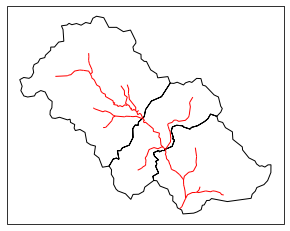

In [10]:
# plot what we have so far -- an image of the HUC and its stream network
fig, ax = workflow.plot.get_ax(crs)

workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
fig.savefig(f'../images/{name}_geometry')

### Generate meshes using river network and watershed shape

Triangulation refinement: refine triangles if their area (in m^2) is greater than A(d), where d is the 
distance from the triangle centroid to the nearest stream.  A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and linearly interpolates between the two endpoints.

2021-07-26 12:56:03,439 - root - INFO: 
2021-07-26 12:56:03,440 - root - INFO: Meshing
2021-07-26 12:56:03,440 - root - INFO: ------------------------------
2021-07-26 12:56:03,455 - root - INFO: Triangulating...
2021-07-26 12:56:03,457 - root - INFO:    190 points and 192 facets
2021-07-26 12:56:03,458 - root - INFO:  checking graph consistency
2021-07-26 12:56:03,458 - root - INFO:  tolerance is set to 1
2021-07-26 12:56:03,460 - root - INFO:  building graph data structures
2021-07-26 12:56:03,462 - root - INFO:  triangle.build...
2021-07-26 12:56:08,265 - root - INFO:   ...built: 7870 mesh points and 15416 triangles
2021-07-26 12:56:08,265 - root - INFO: Plotting triangulation diagnostics
2021-07-26 12:56:09,658 - root - INFO:   min area = 2385.6073303222656
2021-07-26 12:56:09,659 - root - INFO:   max area = 49999.33514404297


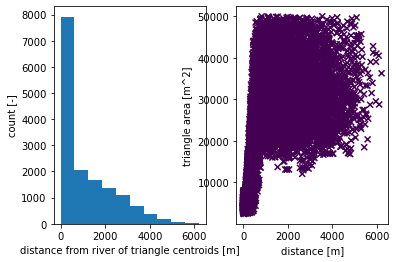

In [11]:
d0 = 100; d1 = 500
A0 = 8000; A1 = 50000 # [100, 310]m

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, distances = workflow.triangulate(watershed, rivers, 
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               diagnostics=True,
                                               )

### Map mesh to DEM

Download a DEM from USGS NED and elevate the triangle nodes to the DEM.

In [12]:
# download the needed rasters
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

2021-07-26 12:56:09,932 - root - INFO: 
2021-07-26 12:56:09,932 - root - INFO: Loading Raster
2021-07-26 12:56:09,933 - root - INFO: ------------------------------
2021-07-26 12:56:09,933 - root - INFO: Collecting raster
2021-07-26 12:56:09,960 - root - INFO: Collecting DEMs to tile bounds: [-106.81032954674818, 38.84352861677468, -106.43913707958494, 39.06593763312722]
2021-07-26 12:56:09,962 - root - INFO:   Need:
2021-07-26 12:56:09,963 - root - INFO:     /Users/uec/code/watershed_workflow/data-library/dem/USGS_NED_1as_n39_w107.tif
2021-07-26 12:56:09,963 - root - INFO:     /Users/uec/code/watershed_workflow/data-library/dem/USGS_NED_1as_n40_w107.tif
2021-07-26 12:56:09,964 - root - INFO: source files already exist!
2021-07-26 12:56:10,061 - root - INFO: ... got raster of shape: (801, 1337)
2021-07-26 12:56:10,072 - root - INFO: ... got raster bounds: (-106.81032954674818, 39.06593763312722, -106.43894065785899, 38.84343763312704)


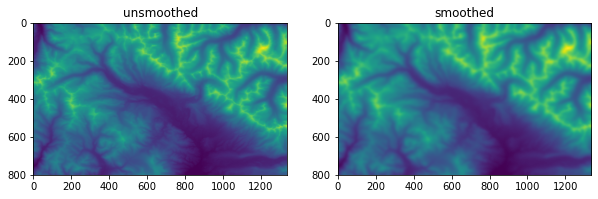

In [13]:
# noting that the DEM is a 30m raster, and we want to run at a coarser resolution of ~100-300m, 
# the DEM will look quite rough.  Smooth a small amount.  Note better algorithms could be used 
# here, but for now we just use Gaussian smoothing.
dem_sm = scipy.ndimage.gaussian_filter(dem, 5, mode='nearest')

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(dem)
axs[0].set_title('unsmoothed')
axs[1].imshow(dem_sm)
txt = axs[1].set_title('smoothed')

In [14]:
# elevate the x,y points onto the DEM to get a z coordinate
mesh_points3 = workflow.elevate(mesh_points2, crs, dem_sm, dem_profile)

2021-07-26 12:56:10,476 - root - INFO: 
2021-07-26 12:56:10,477 - root - INFO: Elevating Triangulation to DEM
2021-07-26 12:56:10,477 - root - INFO: ------------------------------


In [15]:
# construct the 2D mesh
m2 = workflow.mesh.Mesh2D(mesh_points3.copy(), list(mesh_tris))

In [16]:
def edge_height(e):
    return (m2.coords[e[0],2] + m2.coords[e[1],2])/2
print(min(edge_height(e) for e in m2.boundary_edges()))

2853.236230549961


In [17]:
# hydrologically condition the mesh, removing pits
workflow.condition.fill_pits(m2)


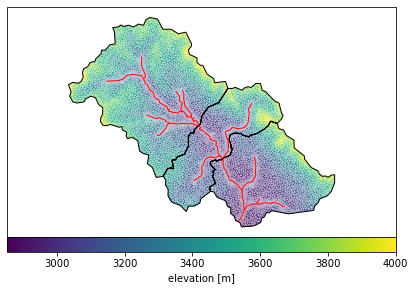

In [18]:
# plot the resulting surface mesh
fig, ax = workflow.plot.get_ax(crs, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

mp = workflow.plot.triangulation(m2.coords, m2.conn, crs, ax=ax, 
                                 color='elevation', edgecolor='white', linewidth=0.2)
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
ax.set_aspect('equal', 'datalim')
txt = cbar.ax.set_xlabel('elevation [m]', loc='center')
fig.savefig(f'../images/{name}_dem')

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed forest.

In [19]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2021-07-26 12:56:11,829 - root - INFO: 
2021-07-26 12:56:11,830 - root - INFO: Loading Raster
2021-07-26 12:56:11,831 - root - INFO: ------------------------------
2021-07-26 12:56:11,832 - root - INFO: Collecting raster
2021-07-26 12:56:11,842 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
2021-07-26 12:56:11,918 - root - INFO: ... got raster of shape: (797, 969)
2021-07-26 12:56:11,930 - root - INFO: ... got raster bounds:

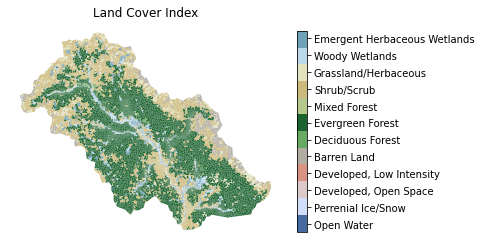

In [20]:
# plot the image
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(lc)

fig, ax = workflow.plot.get_ax(crs)
polys = workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)

workflow.colors.colorbar_index(ncolors=len(np.unique(lc)), cmap=nlcd_cmap, labels = nlcd_labels) 

ax.set_title("Land Cover Index")
ext = ax.axis('off')
fig.savefig(f'../images/{name}_land_cover_raw')

In [21]:
# we don't really need all of these.  Keep Evergreen, Deciduous, Shrub, and merge the rest into "Other"
nlcd_color_new = 99 * np.ones_like(lc)

groupings = {
    42 : ['Evergreen Forest',],
    41 : ['Deciduous Forest', 'Mixed Forest', 'Woody Wetlands'],
    52 : ['Dwarf Scrub', 'Shrub/Scrub', 'Grassland/Herbaceous', 'Sedge/Herbaceous', 
                     'Pasture/Hay', 'Cultivated Crops'],
}

for k,v in groupings.items():
    for label in v:
        index = sources['land cover'].indices[label]
        nlcd_color_new[np.where(lc == index)] = k
    
print(nlcd_color_new)

[42 52 52 ... 52 99 52]


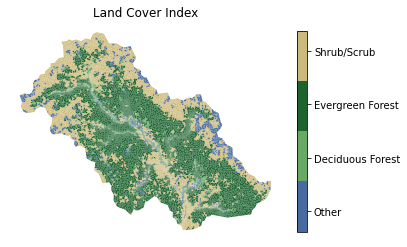

In [22]:
# plot the updated image, adding "other"
nlcd_color_new_other_as_water = np.where(nlcd_color_new == 99, 11, nlcd_color_new)

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                workflow.colors.generate_nlcd_colormap(nlcd_color_new_other_as_water)

# make (water, 11) into (other, 99)
nlcd_labels[0] = 'Other'
nlcd_indices[0] = 99

fig, ax = workflow.plot.get_ax(crs)


polys = workflow.plot.mesh(m2, crs, ax=ax, color=nlcd_color_new_other_as_water, 
                           cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                        facecolor='color', linewidth=0.5)

workflow.colors.colorbar_index(ncolors=len(np.unique(nlcd_color_new_other_as_water)), 
                               cmap=nlcd_cmap, labels = nlcd_labels) 

ax.set_title("Land Cover Index")
ext = ax.axis('off')
fig.savefig(f'../images/{name}_land_cover')



## Subsurface properties

The default model uses GLHYMPS to identify geologic formations, and 

In [23]:
# download the NRCS soils data as shapes and project it onto the mesh

# -- download the shapes
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))
soil_profile, soil_survey, soil_survey_props = workflow.get_shapes(sources['soil structure'], 
                                                                   target_bounds, crs, crs, properties=True)

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = np.array([shp.properties['mukey'] for shp in soil_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_raster, soil_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, soil_survey,
                                              soil_ids, crs)

# -- resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         soil_color_raster, soil_color_profile)

2021-07-26 12:56:20,499 - root - INFO: target bounds: (-562799.3114420066, -365137.54292963934, -534418.261020504, -342804.74996838305)
2021-07-26 12:56:20,500 - root - INFO: 
2021-07-26 12:56:20,501 - root - INFO: Loading shapes
2021-07-26 12:56:20,502 - root - INFO: ------------------------------
2021-07-26 12:56:20,558 - root - INFO: Attempting to download source for target '/Users/uec/code/watershed_workflow/data-library/soil_structure/SSURGO/SSURGO_-106.8075_38.8395_-106.4446_39.0707.shp'
2021-07-26 12:56:20,620 - root - INFO:   Found 1646 shapes.
2021-07-26 12:56:20,631 - root - INFO:   and crs: +init=epsg:4326 +type=crs
2021-07-26 12:56:20,645 - root - INFO: found 108 unique MUKEYs.
2021-07-26 12:56:24,754 - root - INFO: Running Rosetta for van Genutchen parameters
2021-07-26 12:56:24,755 - root - INFO:   database: /Users/uec/code/watershed_workflow/repos/master/workflow_tpls/rosetta/sqlite/rosetta.sqlite
2021-07-26 12:56:24,755 - root - INFO:   model type: 3
2021-07-26 12:56:25

Select only the soils within the watershed

In [24]:
soil_survey_props.set_index('mukey', inplace=True, drop=False)
soil_survey_props = soil_survey_props.loc[np.unique(soil_color), :]

/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_20210603/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


(-564218.3635, -532999.2085000001, -366254.18265000003, -341688.11035)

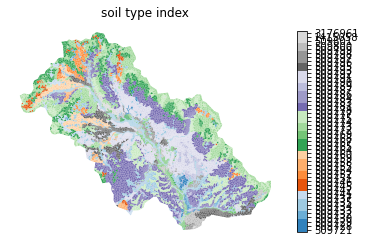

In [25]:
# plot the soil mukey
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color, 
                        cmap=cmap, norm = norm
                       )

workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), cmap=cmap, labels = labels) 

ax.set_title('soil type index')
ax.axis('off')


Median soil thickness [-] =  1.3055


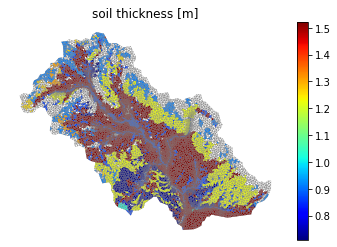

In [26]:
# what does soil thickness look like?
soil_thickness = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[mukey,'thickness [cm]']

soil_thickness = soil_thickness / 100
fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=soil_thickness, edgecolor='gray', cmap='jet')
ax.set_title('soil thickness [m]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
ax.axis('off')

print('Median soil thickness [-] = ', np.nanmedian(soil_thickness))

Median porosity [-] =  0.41185046607359155


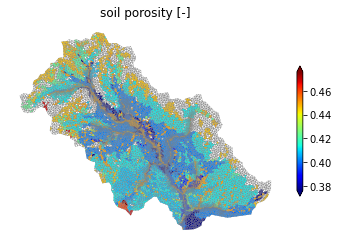

In [27]:
# plot of porosity from SSURGO
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'porosity [-]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet')
ax.set_title('soil porosity [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
ax.axis('off')

print('Median porosity [-] = ', np.nanmedian(iprop))
fig.savefig(f'../images/{name}_soil_porosity')

Min k [m^2] =  1.5871488600044633e-13


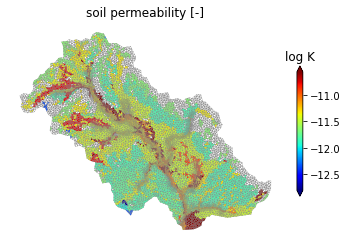

In [28]:
# plot of permeability
iprop = np.empty(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'permeability [m^2]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(iprop), edgecolor='gray', cmap='jet')
ax.set_title('soil permeability [-]')
cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend = "both", shrink = 0.6)
cb.ax.set_title('log K')
ax.axis('off')

print('Min k [m^2] = ', np.nanmin(iprop))
fig.savefig(f'../images/{name}_soil_permeability')

In [29]:
# Note the missing data (white).  This is because some SSURGO map units have no formation with complete 
# information.  So we merge the above available data, filling where possible and dropping regions that
# do not have a complete set of properties.
soil_survey_props_clean = soil_survey_props.copy()

# later scripts expect 'native_index' as a standard name of holding onto the original IDs
soil_survey_props_clean.rename_axis('native_index', inplace=True)
soil_survey_props_clean.rename(columns={'mukey':'native_index'}, inplace=True)

# need thickness in m
soil_survey_props_clean['thickness [cm]'] = soil_survey_props_clean['thickness [cm]']/100.
soil_survey_props_clean.rename(columns={'thickness [cm]':'thickness [m]'}, inplace=True)


def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(soil_survey_props_clean, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(soil_survey_props_clean, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    soil_survey_props_clean.pop(col)
    
# drop nans
soil_survey_props_clean.dropna(inplace=True)
soil_survey_props_clean.reset_index(drop=True, inplace=True)
soil_survey_props_clean



,residual saturation [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],native_index,thickness [m],permeability [m^2],porosity [-],source
0,0.187958,0.000179,1.453833,509728,1.520000,2.915411e-12,0.393614,NRCS
1,0.187958,0.000179,1.453833,509729,1.520000,2.915411e-12,0.393614,NRCS
2,0.182979,0.000137,1.437576,509730,1.520000,1.788174e-12,0.424198,NRCS
3,0.157366,0.000221,1.762072,509732,0.860000,4.744971e-12,0.449752,NRCS
4,0.157366,0.000221,1.762072,509733,0.860000,4.744971e-12,0.449752,NRCS
5,0.181820,0.000166,1.456514,509734,1.520000,2.822000e-12,0.405577,NRCS
6,0.181820,0.000166,1.456514,509735,1.520000,2.822000e-12,0.405577,NRCS
7,0.235202,0.000049,1.416645,509737,0.860000,4.353684e-13,0.468680,NRCS
8,0.162532,0.000207,1.620012,509741,1.305500,4.446627e-12,0.422803,NRCS
9,0.161849,0.000206,1.619348,509742,1.256000,4.507121e-12,0.423244,NRCS


/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_20210603/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


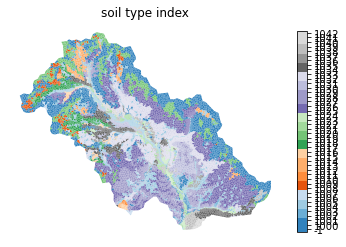

In [30]:
# create a new soil_color, keeping on those that are kept here and re-indexing to ATS indices
soil_color_new = -np.ones_like(soil_color)
for new_id, mukey in enumerate(soil_survey_props_clean['native_index']):
    soil_color_new[np.where(soil_color == mukey)] = 1000+new_id
    
# image the new soil_color
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(soil_color_new, cmap='tab20c')
fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color_new, 
                        cmap=cmap, norm=norm)

workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color_new)), cmap=cmap, labels=labels) 

ax.set_title('soil type index')
ax.axis('off')
fig.savefig(f'../images/{name}_soil_indices')

### GLYHMPS geologic layer

GLYHMPS is complete in that it does not appear to have missing data, but does not have texture properties needed for Water Retention Models.  Instead we rely on scaling laws to fill the data.

In [31]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = workflow.get_shapes(sources['geologic structure'], 
                                                      target_bounds, crs, crs, properties=True)

# -- log the bounds targeted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_raster, geo_color_profile, img_bounds = \
            workflow.color_raster_from_shapes(target_bounds, 10, geo_survey,
                                              geo_ids, crs)

# -- resample the raster to the triangles
geo_color = workflow.values_from_raster(m2.centroids(), crs, 
                                         geo_color_raster, geo_color_profile)


2021-07-26 12:56:53,846 - root - INFO: target bounds: (-562799.3114420066, -365137.54292963934, -534418.261020504, -342804.74996838305)
2021-07-26 12:56:53,846 - root - INFO: 
2021-07-26 12:56:53,847 - root - INFO: Loading shapes
2021-07-26 12:56:53,847 - root - INFO: ------------------------------
2021-07-26 12:56:53,848 - root - INFO: Getting shapes of GLHYMPS on bounds: (-562799.3114420066, -365137.54292963934, -534418.261020504, -342804.74996838305)
2021-07-26 12:56:53,848 - root - INFO:   from file: /Users/uec/code/watershed_workflow/data-library/soil_structure/GLHYMPS/GLHYMPS.shp
2021-07-26 12:56:53,956 - fiona.ogrext - INFO: Failed to auto identify EPSG: 7
/Users/uec/code/watershed_workflow/repos/master/workflow/sources/manager_shape.py:76: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  shps = [s for (i,s) in fid.items(bbox=bounds)]
2021-07-26 12:57:07,521 - root - INFO: ... found 92 shapes
2021-07-2

In [32]:
# select the properties that appear in the mesh
geo_survey_props.set_index('id', inplace=True, drop=False)
geo_survey_props = geo_survey_props.loc[np.unique(geo_color), :]

(-564218.3635, -532999.2085000001, -366254.18265000003, -341688.11035)

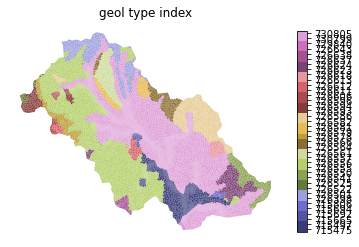

In [33]:
# plot the geologic formation id
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(geo_color, cmap='tab20b')

fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color, 
                        cmap=cmap, norm=norm)

workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels=labels) 

ax.set_title('geol type index')
ax.axis('off')


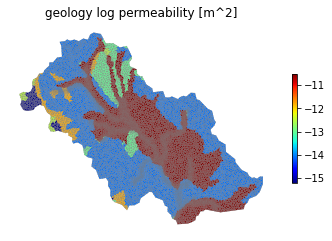

In [34]:
# plot permeability of the underlying geologic layer
iprop = np.empty(geo_color.shape, 'd')
for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'permeability [m^2]']
    
fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=np.log10(iprop), edgecolor='gray', cmap='jet')
cbar = fig.colorbar(mp, shrink=0.5)
ax.set_title('geology log permeability [m^2]')
ax.axis('off')

fig.savefig(f'../images/{name}_geo_permeability')

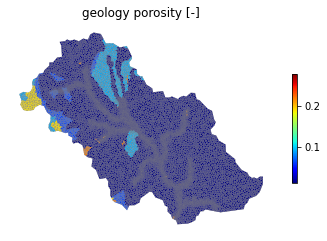

In [35]:
# plot porosity of the geologic layer
iprop = np.empty(geo_color.shape, 'd')
for i in geo_survey_props.index:
    iprop[geo_color == i] = geo_survey_props.loc[i, 'porosity [-]']

fig, ax = workflow.plot.get_ax(crs)
mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=iprop, edgecolor='gray', cmap='jet')
cbar = fig.colorbar(mp, shrink=0.5)
ax.set_title('geology porosity [-]')
ax.axis('off')
fig.savefig(f'../images/{name}_geo_porosity')

In [36]:
# note there are clearly some common regions -- no need to duplicate those with identical values.
geo_survey_props_clean = geo_survey_props.copy()
geo_survey_props_clean.pop('logk_stdev [-]')
geo_survey_props_clean.rename(columns={'id':'native_index'}, inplace=True)


def reindex_remove_duplicates(df, index=None):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

reindex_remove_duplicates(geo_survey_props_clean, 'native_index')
geo_survey_props_clean

,native_index,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-]
0,"(726593, 726611, 726638)",GLHYMPS,1.000000e-13,0.22,0.000294,2.0,0.01
1,"(715497, 715694, 726398, 726541, 726555, 72655...",GLHYMPS,7.943282e-15,0.01,0.000123,2.0,0.01
2,"(715665, 726501, 726561, 726612)",GLHYMPS,1.000000e-13,0.09,0.000436,2.0,0.01
3,"(715475, 715806, 726550, 726618, 726623, 726643)",GLHYMPS,1.258925e-11,0.28,0.002923,2.0,0.01
4,"(726525, 726557, 726606)",GLHYMPS,1.584893e-12,0.06,0.001735,2.0,0.01
5,"(726522, 726564, 726578, 726586, 726594, 72659...",GLHYMPS,3.162278e-13,0.09,0.000775,2.0,0.01
6,"(715692,)",GLHYMPS,6.309573e-16,0.19,0.000025,2.0,0.01
7,"(729840, 730799, 730805)",GLHYMPS,3.019952e-11,0.01,0.007574,2.0,0.01


/Users/Shared/ornldev/code/miniconda3/envs/watershed_workflow_20210603/lib/python3.9/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


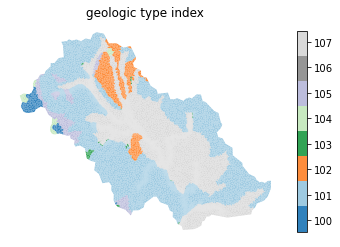

In [37]:
# create a new geologic layer color, keeping on those that are kept here and re-indexing to ATS indices
geo_color_new = -np.ones_like(geo_color)
for new_id, old_id_dups in enumerate(geo_survey_props_clean['native_index']):
    for old_id in old_id_dups:
        geo_color_new[np.where(geo_color == old_id)] = 100+new_id
    
# image the new geo_color
indices, cmap, norm, ticks, labels = workflow.colors.generate_indexed_colormap(geo_color_new, cmap='tab20c')
fig, ax = workflow.plot.get_ax(crs)

mp = workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color_new, 
                        cmap=cmap, norm=norm)

workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color_new)), cmap=cmap, labels=labels) 

ax.set_title('geologic type index')
ax.axis('off')
fig.savefig(f'../images/{name}_geo_indices')

## Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [38]:
DTB_source = workflow.source_list.structure_sources['SoilGrids2017']
DTB_profile, DTB_raster = workflow.get_raster_on_shape(DTB_source, watershed.exterior(), crs, 
                                                       nodata=-99999, variable='BDTICM')

# resample the raster to the triangles
DTB_raster = DTB_raster/100 #convert from cm to m
DTB = workflow.values_from_raster(m2.centroids(), crs, DTB_raster, DTB_profile, algorithm='piecewise bilinear')
DTB = np.where(DTB >= 0, DTB, np.nan)

2021-07-26 12:57:18,769 - root - INFO: 
2021-07-26 12:57:18,770 - root - INFO: Loading Raster
2021-07-26 12:57:18,771 - root - INFO: ------------------------------
2021-07-26 12:57:18,771 - root - INFO: Collecting raster
2021-07-26 12:57:18,777 - root - INFO: CRS: EPSG:4326
2021-07-26 12:57:18,778 - root - INFO: filename: /Users/uec/code/watershed_workflow/data-library/soil_structure/SoilGrids2017_US/BDTICM_M_250m_ll_us.tif
2021-07-26 12:57:18,871 - root - INFO: ... got raster of shape: (98, 170)
2021-07-26 12:57:18,882 - root - INFO: ... got raster bounds: (-106.80208624499215, 39.05625167099549, -106.447919634992, 38.852085036995405)


bounds in my_crs: (-106.80032954674817, 38.853528616774675, -106.44913707958494, 39.05593763312722)


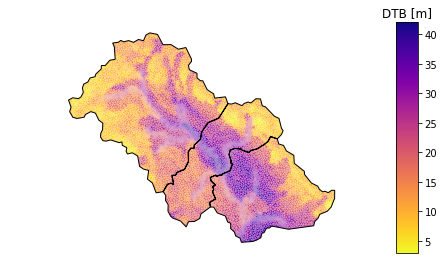

In [39]:
# plot the resulting surface mesh
fig, ax = workflow.plot.get_ax(crs, window=[0.05,0.1,0.9,0.8])
cbax = fig.add_axes([.95,0.1,0.05,0.8])

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color=DTB, cmap='plasma_r', edgecolor='white', linewidth=0.1)
cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

ax.set_aspect('equal', 'datalim')
ax.axis('off')

cbar.ax.set_title('DTB [m]')
fig.savefig(f'../images/{name}_dtb')

## A combined, complete product?

As a default, we would like a material-driven (e.g. not fields for porosity, perm, etc, but soil classes, each with a common porosity/permeability/vG curve) default that is valid everywhere.  That makes it clear that we must rely on GLHYMPS as the only material-based product that is valid everywhere.  Other products may be layered on top of this, replacing GLHYMPS values, but the underlying layer should be based on GLHYMPS.  To fill in the van Genuchten properties, we relate alpha to permeability and choose a single common n and s_r.

Where available, we then choose to use SSURGO as a layer on top of GLHYMPS.  So start by using all GLHYMPS values, then override ones where SSURGO is valid with those values.  This will be the second model, and has then three layers -- a bedrock layer, a soil layer from 0 to 2m, and a geologic layer, using GLHYMPS values.  SoilGrids depth-to-bedrock will be used to provide the transition between bedrock and (where > 2m) the GLHYMPS "geologic" layer or (where < 2m) the SSURGO "soil" layer.  Where SSURGO has no values, the underlying GLHYMPS values will be used even in the top 2m.


Note, all integer IDs in mesh files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs. 999 is reserved for bedrock.
* 1000-9999 : soil layer material IDs




In [40]:
# map SSURGO mukey to ATS_ID
soil_survey_props_clean['ats_id'] = range(1000, 1000+len(soil_survey_props_clean))
soil_survey_props_clean.set_index('ats_id', inplace=True)

# map GLHYMPS id to ATS_ID
geo_survey_props_clean['ats_id'] = range(100, 100+len(geo_survey_props_clean))
geo_survey_props_clean.set_index('ats_id', inplace=True)

bedrock_props = workflow.soil_properties.get_bedrock_properties()

# merge the properties databases
subsurface_props = pandas.concat([geo_survey_props_clean,
                                  soil_survey_props_clean,
                                  bedrock_props])

# save the properties to disk for use in generating input file
outputs['subsurface_properties_filename'] = f'../data-processed/{name}_subsurface_properties.csv'
subsurface_props.to_csv(outputs['subsurface_properties_filename'])
subsurface_props


,native_index,source,permeability [m^2],porosity [-],van Genuchten alpha [Pa^-1],van Genuchten n [-],residual saturation [-],thickness [m]
ats_id,,,,,,,,
100,"(726593, 726611, 726638)",GLHYMPS,1.000000e-13,0.220000,0.000294,2.000000,0.010000,NaN
101,"(715497, 715694, 726398, 726541, 726555, 72655...",GLHYMPS,7.943282e-15,0.010000,0.000123,2.000000,0.010000,NaN
102,"(715665, 726501, 726561, 726612)",GLHYMPS,1.000000e-13,0.090000,0.000436,2.000000,0.010000,NaN
103,"(715475, 715806, 726550, 726618, 726623, 726643)",GLHYMPS,1.258925e-11,0.280000,0.002923,2.000000,0.010000,NaN
104,"(726525, 726557, 726606)",GLHYMPS,1.584893e-12,0.060000,0.001735,2.000000,0.010000,NaN
105,"(726522, 726564, 726578, 726586, 726594, 72659...",GLHYMPS,3.162278e-13,0.090000,0.000775,2.000000,0.010000,NaN
106,"(715692,)",GLHYMPS,6.309573e-16,0.190000,0.000025,2.000000,0.010000,NaN
107,"(729840, 730799, 730805)",GLHYMPS,3.019952e-11,0.010000,0.007574,2.000000,0.010000,NaN
1000,509728,NRCS,2.915411e-12,0.393614,0.000179,1.453833,0.187958,1.520000


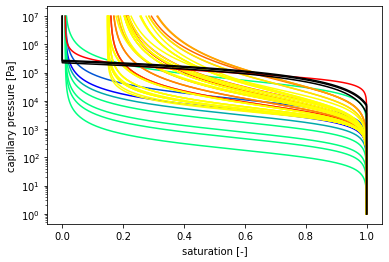

In [41]:
# make a giant plot of all the WRMs
import plot_wrm # $ATS_SRC_DIR/tools/utils
fig = plt.figure()
ax = fig.add_subplot(111)

cm_gl = workflow.colors.cm_mapper(100, 103, 'winter')
cm_ss = workflow.colors.cm_mapper(1000,1017, 'autumn')

for i in subsurface_props.index:
    if i < 999:
        cl = cm_gl(i)
    else:
        cl = cm_ss(i)
    alpha = subsurface_props.loc[i]['van Genuchten alpha [Pa^-1]']
    n = subsurface_props.loc[i]['van Genuchten n [-]']
    sr = subsurface_props.loc[i]['residual saturation [-]']
    vg = plot_wrm.VanGenuchten(alpha, n, sr)
    plot_wrm.plot(vg, ax, cl)
    
# include wilting point limiters
wp1 = plot_wrm.WiltingPointLimiter(7400, 275000)
wp2 = plot_wrm.WiltingPointLimiter(6600, 255000)
wp3 = plot_wrm.WiltingPointLimiter(3500, 224000)
for wp in [wp1, wp2, wp3]:
    plot_wrm.plot(wp, ax, 'k')

    
plt.show()

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [42]:
# here we choose the bottom of the domain to be the maximum of the depth to bedrock.  
# This is really up to the user...
total_thickness = np.ceil(DTB.max())
print(f'total thickness: {total_thickness} m')

total_thickness = 41.0

total thickness: 42.0 m


In [43]:
# Generate a dz structure for the top 2m of soil
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)
print(sum(dzs))

[0.0500016  0.05030145 0.06625834 0.1110568  0.22600204 0.49640501
 0.49997989 0.49999487]
2.0


In [44]:
# this looks like it would work out, with rounder numbers:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs_soil))

2.0


In [45]:
# 41m total thickness, minus 2m soil thickness, leaves us with 39 meters to make up.
# optimize again...
dzs2, res2 = workflow.mesh.optimize_dzs(1, 10, 39, 8)
print(dzs2)
print(sum(dzs2))

# how about...
dzs_geo = [1.0, 3.0,] + 7*[5.0,]
print(dzs_geo)
print(sum(dzs_geo))

[ 1.43810942  2.49456441  5.06733261  9.99999356  9.99999999 10.        ]
39.0
[1.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
39.0


In [46]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    br_or_geo = np.where(depth < DTB, geo_color_new, 999)
    soil_or_br_or_geo = np.where(np.bitwise_and(soil_color_new > 0, depth < soil_thickness),
                                 soil_color_new,
                                 br_or_geo)
    
    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(np.where(depth < DTB, geo_color_new, 999))
    depth += 0.5 * dz

# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2021-07-26 12:57:20,621 - root - INFO: Cell summary:
2021-07-26 12:57:20,621 - root - INFO: ------------------------------------------------------------
2021-07-26 12:57:20,621 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2021-07-26 12:57:20,622 - root - INFO: ------------------------------------------------------------
2021-07-26 12:57:20,622 - root - INFO:  00 	| 00 	|  101 	|   0.050000 	|   0.000000
2021-07-26 12:57:20,623 - root - INFO:  01 	| 01 	|  101 	|   0.050000 	|   0.050000
2021-07-26 12:57:20,623 - root - INFO:  02 	| 02 	|  101 	|   0.050000 	|   0.100000
2021-07-26 12:57:20,623 - root - INFO:  03 	| 03 	|  101 	|   0.120000 	|   0.150000
2021-07-26 12:57:20,624 - root - INFO:  04 	| 04 	|  101 	|   0.230000 	|   0.270000
2021-07-26 12:57:20,753 - root - INFO:  05 	| 05 	|  101 	|   0.500000 	|   0.500000
2021-07-26 12:57:20,753 - root - INFO:  06 	| 06 	|  101 	|   0.500000 	|   1.000000
2021-07-26 12:57:20,754 - root - INFO:  07 	| 07 	|  101 	|   0.500000 	|   1.5

In [47]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [48]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

for index, nlcd_name in zip(nlcd_indices, nlcd_labels):
    where = np.where(nlcd_color_new == index)[0]
    print(index, nlcd_name, len(where))
    ss = workflow.mesh.SideSet(nlcd_name, int(index), 
                            [surf_ss.elem_list[w] for w in where],
                            [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

99 Other 1416
41 Deciduous Forest 1400
42 Evergreen Forest 7787
52 Shrub/Scrub 4813


In [49]:
# save to disk
outputs['mesh_filename'] = f'../data-processed/{name}.exo'
try:
    os.remove(outputs['mesh_filename'])
except FileNotFoundError:
    pass
m3.write_exodus(outputs['mesh_filename'])



You are using exodus.py v 1.20.7 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ../data-processed/TaylorHeadwaters.exo
Closing exodus file: ../data-processed/TaylorHeadwaters.exo


## Collect the DayMet raster covering this area

Note that here we need two files -- the actual data and the typical year data.

The first cell downloads the raw data and generates the actual data file used by ATS, the second cell averages days, smooths the data, and writes a typical year.

In [50]:
start = "1-1980"
end = "365-2020"
bounds = watershed.exterior().bounds

outputs['daymet_filename'] = f'../data-processed/{name}_DayMet_1980_2020.h5'

dat, x, y = workflow.daymet.collectDaymet(bounds, crs, start, end)
ats = workflow.daymet.daymetToATS(dat)
attrs = workflow.daymet.getAttrs(bounds, start, end)
workflow.daymet.writeHDF5(ats, x, y, attrs, outputs['daymet_filename'])

2021-07-26 12:57:29,635 - root - INFO: downloading variables: ['tmin', 'tmax', 'prcp', 'srad', 'vp', 'swe', 'dayl']
2021-07-26 12:57:29,674 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:29,675 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_tmin_1980_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:29,719 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:29,720 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_tmax_1980_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:29,766 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:29,767 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_prcp_1

2021-07-26 12:57:30,881 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_swe_1983_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:30,927 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:30,928 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_dayl_1983_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:30,971 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:30,972 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_tmin_1984_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:31,017 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:31,018 - root - INFO:   Using existing: /Users/uec/code/w

2021-07-26 12:57:32,146 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:32,147 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_vp_1987_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:32,191 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:32,192 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_swe_1987_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:32,239 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:32,240 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_dayl_1987_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:32,283 - root - INFO: Collecting DayMet file to tile bounds

2021-07-26 12:57:33,388 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:33,389 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_srad_1991_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:33,433 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:33,434 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_vp_1991_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:33,478 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:33,480 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_swe_1991_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:33,523 - root - INFO: Collecting DayMet file to tile bounds

2021-07-26 12:57:34,608 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:34,609 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_prcp_1995_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:34,655 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:34,657 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_srad_1995_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:34,703 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:34,704 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_vp_1995_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:34,749 - root - INFO: Collecting DayMet file to tile bound

2021-07-26 12:57:35,855 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:35,856 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_tmax_1999_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:35,903 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:35,903 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_prcp_1999_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:35,947 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:35,948 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_srad_1999_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:35,991 - root - INFO: Collecting DayMet file to tile bou

2021-07-26 12:57:37,102 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:37,103 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_tmin_2003_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:37,147 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:37,148 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_tmax_2003_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:37,192 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:37,193 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_prcp_2003_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:37,238 - root - INFO: Collecting DayMet file to tile bou

2021-07-26 12:57:38,348 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:38,349 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_dayl_2006_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:38,391 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:38,392 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_tmin_2007_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:38,436 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:38,437 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_tmax_2007_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:38,483 - root - INFO: Collecting DayMet file to tile bou

2021-07-26 12:57:39,591 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:39,592 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_swe_2010_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:39,638 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:39,639 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_dayl_2010_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:39,683 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:39,685 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_tmin_2011_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:39,731 - root - INFO: Collecting DayMet file to tile boun

2021-07-26 12:57:40,847 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:40,848 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_vp_2014_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:40,892 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:40,893 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_swe_2014_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:40,938 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:40,939 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_dayl_2014_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:40,986 - root - INFO: Collecting DayMet file to tile bounds

2021-07-26 12:57:42,093 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:42,094 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_srad_2018_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:42,141 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:42,142 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_vp_2018_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:42,187 - root - INFO: Collecting DayMet file to tile bounds: [-106.8174, 38.8296, -106.43469999999999, 39.0806]
2021-07-26 12:57:42,189 - root - INFO:   Using existing: /Users/uec/code/watershed_workflow/data-library/meteorology/daymet/daymet_swe_2018_39.0806x-106.8174_38.8296x-106.4347.nc
2021-07-26 12:57:42,231 - root - INFO: Collecting DayMet file to tile bounds

In [51]:
outputs['daymet_spinup_filename'] = f'../data-processed/{name}_DayMet_typical_1980_2020.h5'

ats_typ = workflow.daymet.daymetToATS(dat, smooth=True, smooth_filter=True, nyears=40)
workflow.daymet.writeHDF5(ats_typ, x, y, attrs, outputs['daymet_spinup_filename'])

2021-07-26 12:58:06,846 - root - INFO: input dat shape: (14965, 31, 34)
2021-07-26 12:58:06,847 - root - INFO: Converting to ATS met input
2021-07-26 12:58:06,848 - root - INFO: averaging daymet by taking the average for each day across the actual years.
2021-07-26 12:58:06,861 - root - INFO: smoothing tmin using savgol filter, window = 61 d, poly order = 2
2021-07-26 12:58:06,896 - root - INFO: smoothing tmax using savgol filter, window = 61 d, poly order = 2
2021-07-26 12:58:06,931 - root - INFO: smoothing prcp using savgol filter, window = 61 d, poly order = 2
2021-07-26 12:58:06,969 - root - INFO: smoothing srad using savgol filter, window = 61 d, poly order = 2
2021-07-26 12:58:07,058 - root - INFO: smoothing vp using savgol filter, window = 61 d, poly order = 2
2021-07-26 12:58:07,147 - root - INFO: smoothing swe using savgol filter, window = 61 d, poly order = 2
2021-07-26 12:58:07,232 - root - INFO: smoothing dayl using savgol filter, window = 61 d, poly order = 2
2021-07-26 12

## Generate files for Leaf Area Index

In addition to meteorological forcing data, we need land cover leaf area index data.  Typically this can be smoother than the DayMet, and our default source for this, MODIS, is not currently automated.  Therefore this assumes you have already acquired the raw MODIS data (note -- get Pin to add his scripts for this!)

MODIS is available from 2002 to present -- we generate a typical year and can use that for all years, though probably we should do something smarter if possible.

In [52]:
def plot(df, form, axs):
    cm = workflow.colors.enumerated_colors(3)
    i = 0
    for k in df.keys():
        if not k.startswith('time'):
            axs[i].plot(df['time [d]'], df[k], form, color=cm[i])
            axs[i].set_ylabel(k)
            i += 1

In [53]:
# load the raw MODIS data and covert it to pandas
#raw_modis_filename = f'../data-raw/{name}_MODIS_LAI-072002_122019.h5'
raw_modis_filename = f'../data-raw/CoalCreek_MODIS_LAI-072002_122019.h5'

d = h5py.File(raw_modis_filename,'r')
df = pandas.DataFrame()
for k in d.keys():
    df[k] = d[k][:]

df['time [d]'] = df['time [s]']/86400

In [54]:
# interpolate this time series into a daily time series
ts = np.arange(8214, 14600, 1)

df_interp = pandas.DataFrame()
df_interp['time [d]'] = ts

for k in df.keys():
    if k != 'time [s]':
        f = scipy.interpolate.interp1d(df['time [d]'][:], df[k][:])
        df_interp[k] = f(ts)

df = df_interp

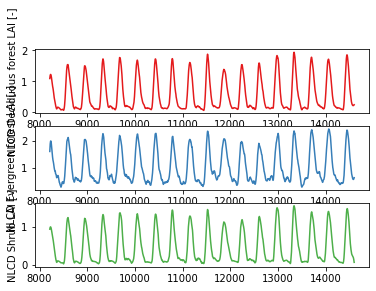

In [55]:
# smooth the data
df_smooth = pandas.DataFrame()
df_smooth['time [d]'] = df['time [d]']
for k in df.keys():
    if k != 'time [d]':
        df_smooth[k] = scipy.signal.savgol_filter(df[k], 101, 3)

        
# plot comparison
fig = plt.figure()
axs = fig.subplots(3,1)
#plot(df, '-', axs)
plot(df_smooth, '-', axs)
plt.show()
  

In [56]:
# add time back and write to disk
outputs['modis_filename'] = f'../data-processed/{name}_MODIS_LAI_smoothed_2002_2020.h5'

df_smooth['time [s]'] = df_smooth['time [d]']*86400
with h5py.File(outputs['modis_filename'],'w') as fid:
    for k in df_smooth:
        fid.create_dataset(k, data=df_smooth[k][:])


In [57]:
df = df_smooth

# split into n_years dataframes, one per year
df_yr = []
for year in range(23, 39):
    yr = df.loc[df_interp['time [d]'] >= year*365]
    df_yr.append(yr.loc[yr['time [d]'] < (year+1)*365])

# average across the years
df_avg = pandas.DataFrame()
for yr in df_yr:
    for k in yr.keys():
        if not k.startswith('time'):
            if k in df_avg:
                df_avg[k] = df_avg[k].array + yr[k].array
            else:
                df_avg[k] = yr[k].copy()

for k in df_avg.keys():
    df_avg[k] = df_avg[k][:] / len(df_yr)

df_avg['time [d]'] = df['time [d]']


In [58]:
# replicate 40 times to make 40 years (remem)
# tile all data to repeat n_year times
df_rep = pandas.DataFrame()
for key in df_avg:
    if not key.startswith('time'):
        df_rep[key] = np.tile(df_avg[key].array, 40)
        assert(len(df_rep) == 40*365)
    
# time is simply daily data
df_rep['time [s]'] = 86400. * np.arange(0., 40 * 365., 1.)
df_rep['time [d]'] = np.arange(0., 40 * 365., 1.)

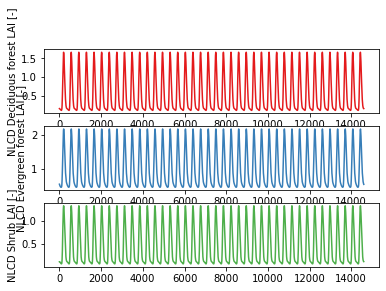

In [59]:
# plot this and make sure it looks right
fig = plt.figure()
axs = fig.subplots(3,1)
plot(df_rep, '-', axs)
plt.show()

In [60]:
# write to disk
outputs['modis_typical_filename'] = f'../data-processed/{name}_MODIS_LAI_typical_1980_2020.h5'

with h5py.File(outputs['modis_typical_filename'],'w') as fid:
    for k in df_rep:
        fid.create_dataset(k, data=df_rep[k][:])


## Write ATS input files

We now generate three input files -- two for spinup (steadystate solution and cyclic steadystate solution) and one for transient runs.

Steadystate has its own physics, but cyclic steadystate and transient share a common set of physics.  Each have their own met data strategy.

The first step is to generate the sections of xml that will replace parts of the template files.  This is done prior to loading any templates to make clear that these are totally generated from scratch using the ats_input_spec tool.

Note that throughout, we will assume an additional level of folder nesting, e.g. runs will be completed in '../spinup-CoalCreek/run0', meaning that we have to append an extra '../' to the start of all filenames.  This makes it easier to deal with mistakes, continued runs, etc.

In [61]:
# get an ATS "main" input spec list
main_list = ats_input_spec.public.get_main()

In [62]:
# add the subsurface and surface domains
#
# Note this also adds a "computational domain" region to the region list, and a vis spec 
# for "domain"
mesh_filename = os.path.join('..', outputs['mesh_filename'])

ats_input_spec.public.add_domain(main_list, 
                                 domain_name='domain', 
                                 dimension=3, 
                                 mesh_type='read mesh file', 
                                 mesh_args={'file':mesh_filename})
main_list['mesh']['domain']['build columns from set'] = 'surface'

# Note this also adds a "surface domain" region to the region list and a vis spec for 
# "surface"
ats_input_spec.public.add_domain(main_list,
                                domain_name='surface',
                                dimension=2,
                                mesh_type='surface',
                                mesh_args={'surface sideset name':'surface'})

# Add the snow and canopy domains, which are aliases to the surface
ats_input_spec.public.add_domain(main_list,
                                domain_name='snow',
                                dimension=2,
                                mesh_type='aliased',
                                mesh_args={'target':'surface'})
ats_input_spec.public.add_domain(main_list,
                                domain_name='canopy',
                                dimension=2,
                                mesh_type='aliased',
                                mesh_args={'target':'surface'})

# add the "surface boundary" list
ats_input_spec.public.add_region(main_list,
                                region_name='surface boundary',
                                region_type='boundary',
                                region_args={'entity': 'FACE'})

def add_labeled_set(ls_name, label, entity_kind):
    """Helper function to add labeled sets to the main list"""
    ats_input_spec.public.add_region(main_list,
                                    region_name=ls_name,
                                    region_type='labeled set',
                                    region_args={'label' : str(label), 
                                                 'file' : mesh_filename,
                                                 'format' : 'Exodus II',
                                                 'entity' : entity_kind})

# add the bottom and surface sets
add_labeled_set('bottom_face', 1, 'FACE')
add_labeled_set('surface', 2, 'FACE')

# add the NLCD labeled sets
for index, nlcd_name in zip(nlcd_indices, nlcd_labels):
    add_labeled_set(nlcd_name, index, 'FACE')

# add soil sets: note we need a way to name the set, so we use, e.g. SSURGO-MUKEY.
def soil_set_name(ats_id):
    if ats_id == 999:
        return 'bedrock'
    source = subsurface_props.loc[ats_id]['source']
    native_id = subsurface_props.loc[ats_id]['native_index']
    if type(native_id) in [tuple,list]:
        native_id = native_id[0]
    return f"{source}-{native_id}"

for ats_id in subsurface_props.index:
    set_name = soil_set_name(ats_id)
    add_labeled_set(set_name, ats_id, 'CELL')

print(main_list)

mesh [mesh-typed-spec-list] : [complete]
  domain [TypedCollection] : [complete]
    mesh type [string] : read mesh file
    read mesh file parameters [unknown derived parameter] : [complete]
      file [string] : ../../data-processed/TaylorHeadwaters.exo
    verify mesh [bool] : false
    deformable mesh [bool] : false
    build columns from set [string] : surface
    partitioner [string] : zoltan_rcb
  surface [TypedCollection] : [complete]
    mesh type [string] : surface
    surface parameters [unknown derived parameter] : [complete]
      surface sideset name [string] : surface
      verify mesh [bool] : false
      export mesh to file [string] : [optional]
    verify mesh [bool] : false
    deformable mesh [bool] : false
    build columns from set [string] : [optional]
    partitioner [string] : zoltan_rcb
  snow [TypedCollection] : [complete]
    mesh type [string] : aliased
    aliased parameters [unknown derived parameter] : [complete]
      target [string] : surface
    verif

In [63]:
# next write a land-cover section for each NLCD type
land_cover_list = ats_input_spec.public.known_specs['land-cover-spec-list']
main_list['state']['initial conditions']['land cover types'] = land_cover_list

def add_land_cover_default(main, lc_name):
    """Adds a default land-cover type to the spec."""
    lc = main['state']['initial conditions']['land cover types'].append_empty(lc_name)
    
    # set some basic defaults
    lc['Priestley-Taylor alpha of snow [-]'] = 1.26
    lc['Priestley-Taylor alpha of bare ground [-]'] = 1.26
    lc['Priestley-Taylor alpha of canopy [-]'] = 1.26
    lc['Priestley-Taylor alpha of transpiration [-]'] = 1.26

    lc['albedo of bare ground [-]'] = 0.4
    lc['emissivity of bare ground [-]'] = 0.98
    lc['albedo of canopy [-]'] = 0.11
    lc['emissivity of canopy [-]'] = 0.95
    
    lc["Beer's law extinction coefficient, shortwave [-]"] = 0.6
    lc["Beer's law extinction coefficient, longwave [-]"] = 5
    
    lc["snow transition depth [m]"] = 0.02
    lc["dessicated zone thickness [m]"] = 0.1
    lc["Clapp and Hornberger b [-]"] = 1
    
    # defaults for grass/no vei
    lc['rooting depth max [m]'] = 5.
    lc['rooting profile alpha [-]'] = 11.0
    lc['rooting profile beta [-]'] = 2.0
    
    
    # Note, the mafic potential values are likely pretty bad for the types of van Genuchten 
    # curves we are using (https://www.sciencedirect.com/science/article/pii/S0168192314000483).
    # Likely they need to be modified.  Note that these values are in [mm] from CLM TN 4.5 table 8.1, so the 
    # factor of 10 converts to [Pa].
    #
    # instead of using a factor of 10, we use a factor of 1 for closed and .1 for open to make this more 
    # physically viable for our VG models
    lc['mafic potential at fully closed stomata [Pa]'] = 275000.
    lc['mafic potential at fully open stomata [Pa]'] = 74000. * .1
    
    # by default we let the LAI take care of this rather than turn off deciduous 
    # transpiration manually the way that PRMS does it. 
    lc['leaf on time [doy]'] = -1
    lc['leaf off time [doy]'] = -1
    return lc

# add default lists for all types
for index, nlcd_name in zip(nlcd_indices, nlcd_labels):
    lc = add_land_cover_default(main_list, nlcd_name)

# update some defaults
# ['Other', 'Deciduous Forest', 'Evergreen Forest', 'Shrub/Scrub']
# note, these are from the CLM Technical Note v4.5
#
# Rooting depth curves from CLM TN 4.5 table 8.3
#
# Note, the mafic potential values are likely pretty bad for the types of van Genuchten 
# curves we are using (ETC -- add paper citation about this topic).  Likely they need
# to be modified.  Note that these values are in [mm] from CLM TN 4.5 table 8.1, so the 
# factor of 10 converts to [Pa]
#
# Note, albedo of canopy taken from CLM TN 4.5 table 3.1
land_cover_list['Evergreen Forest']['rooting profile alpha [-]'] = 7.0
land_cover_list['Evergreen Forest']['rooting profile beta [-]'] = 2.0
land_cover_list['Evergreen Forest']['rooting depth max [m]'] = 10.0
land_cover_list['Evergreen Forest']['mafic potential at fully closed stomata [Pa]'] = 255000
land_cover_list['Evergreen Forest']['mafic potential at fully open stomata [Pa]'] = 66000 * .1
land_cover_list['Evergreen Forest']['albedo of canopy [-]'] = 0.07

land_cover_list['Deciduous Forest']['rooting profile alpha [-]'] = 6.0
land_cover_list['Deciduous Forest']['rooting profile beta [-]'] = 2.0
land_cover_list['Deciduous Forest']['rooting depth max [m]'] = 10.0
land_cover_list['Deciduous Forest']['mafic potential at fully closed stomata [Pa]'] = 224000
land_cover_list['Deciduous Forest']['mafic potential at fully open stomata [Pa]'] = 35000 * .10
land_cover_list['Deciduous Forest']['albedo of canopy [-]'] = 0.1

print(land_cover_list)

Other [TypedCollection] : [complete]
  rooting depth max [m] [double] : 5.00000000
  rooting profile alpha [-] [double] : 11.00000000
  rooting profile beta [-] [double] : 2.00000000
  mafic potential at fully closed stomata [Pa] [double] : 275000.00000000
  mafic potential at fully open stomata [Pa] [double] : 7400.00000000
  leaf on time [doy] [double] : -1.00000000
  leaf off time [doy] [double] : -1.00000000
  Priestley-Taylor alpha of snow [-] [double] : 1.26000000
  Priestley-Taylor alpha of bare ground [-] [double] : 1.26000000
  Priestley-Taylor alpha of canopy [-] [double] : 1.26000000
  Priestley-Taylor alpha of transpiration [-] [double] : 1.26000000
  interception coefficient [-] [double] : nan
  albedo of bare ground [-] [double] : 0.40000000
  emissivity of bare ground [-] [double] : 0.98000000
  albedo of canopy [-] [double] : 0.11000000
  emissivity of canopy [-] [double] : 0.95000000
  Beer's law extinction coefficient, shortwave [-] [double] : 0.60000000
  Beer's law 

In [64]:
# finally, we write soil property specs for porosity, permeability, and WRMs
poro_eval = main_list['state']['field evaluators'].append_empty('base_porosity')
poro_eval.set_type('independent variable', ats_input_spec.public.known_specs['independent-variable-evaluator-spec'])
poro_eval['constant in time'] = True

perm_eval = main_list['state']['field evaluators'].append_empty('permeability')
perm_eval.set_type('independent variable', ats_input_spec.public.known_specs['independent-variable-evaluator-spec'])
perm_eval['constant in time'] = True

wrm_eval = main_list['state']['field evaluators'].append_empty('saturation_liquid')
wrm_eval.set_type('WRM rel perm', ats_input_spec.public.known_specs['rel-perm-evaluator-spec'])
wrm_eval['boundary rel perm strategy'] = 'surface rel perm'
wrm_eval['permeability rescaling'] = 1e7


print(main_list['state']['field evaluators'])

base_porosity [TypedCollection] : [incomplete]
  field evaluator type [string] : independent variable
  constant in time [bool] : true
  function [composite-vector-function-spec-list] : [incomplete]
    
permeability [TypedCollection] : [incomplete]
  field evaluator type [string] : independent variable
  constant in time [bool] : true
  function [composite-vector-function-spec-list] : [incomplete]
    
saturation_liquid [TypedCollection] : [incomplete]
  field evaluator type [string] : WRM rel perm
  use density on viscosity in rel perm [bool] : true
  boundary rel perm strategy [string] : surface rel perm
  minimum rel perm cutoff [double] : 0.00000000
  permeability rescaling [double] : 10000000.00000000
  WRM parameters [wrm-typedinline-spec-list] : [incomplete]
    


In [65]:
def add_region_set_value(evaluator, ats_id, val):
    region = soil_set_name(ats_id)
    my_func = evaluator['function'].append_empty(region)
    my_func['region'] = region
    my_func['component'] = 'cell'
    my_func_const = my_func['function'].set_type('constant', 
                                                 ats_input_spec.public.known_specs['function-constant-spec'])
    my_func_const['value'] = float(val)

def add_wrm(evaluator, ats_id, props):
    region = soil_set_name(ats_id)
    wrm = wrm_eval['WRM parameters'].append_empty(region)
    wrm.set_type('van Genuchten', ats_input_spec.public.known_specs['WRM-van-Genuchten-spec'])

    wrm['region'] = region
    wrm['van Genuchten alpha [Pa^-1]'] = float(props['van Genuchten alpha [Pa^-1]'])
    wrm['van Genuchten n [-]'] = float(props['van Genuchten n [-]'])
    wrm['residual saturation [-]'] = float(props['residual saturation [-]'])
    wrm['smoothing interval width [saturation]'] = 0.05
    
    
for ats_id in subsurface_props.index:
    add_region_set_value(poro_eval, ats_id, subsurface_props.loc[ats_id]['porosity [-]'])
    add_region_set_value(perm_eval, ats_id, subsurface_props.loc[ats_id]['permeability [m^2]'])
    add_wrm(wrm_eval, ats_id, subsurface_props.loc[ats_id])

    
print(main_list['state']['field evaluators'])

base_porosity [TypedCollection] : [complete]
  field evaluator type [string] : independent variable
  constant in time [bool] : true
  function [composite-vector-function-spec-list] : [complete]
    GLHYMPS-726593 [TypedCollection] : [complete]
      region [string] : GLHYMPS-726593
      component [string] : cell
      function [function-typedsublistdash-spec] : [complete]
        function-constant [False] : [complete]
          value [double] : 0.22000000
    GLHYMPS-715497 [TypedCollection] : [complete]
      region [string] : GLHYMPS-715497
      component [string] : cell
      function [function-typedsublistdash-spec] : [complete]
        function-constant [False] : [complete]
          value [double] : 0.01000000
    GLHYMPS-715665 [TypedCollection] : [complete]
      region [string] : GLHYMPS-715665
      component [string] : cell
      function [function-typedsublistdash-spec] : [complete]
        function-constant [False] : [complete]
          value [double] : 0.09000000
    

In [66]:
outputs['generated_ats'] = f'../data-processed/{name}_generated_ats.xml'
ats_input_spec.io.write(main_list, outputs['generated_ats'])
main_xml = ats_input_spec.io.to_xml(main_list)

/Users/uec/code/ats/ats_python/rethink/ats_input_spec/io.py:43: UserWarning: Creating an incomplete XML object, missing entries!
  warnings.warn('Creating an incomplete XML object, missing entries!')


In [67]:
def populate_basic_properties(xml):
    """This function updates an xml object with the above properties for mesh, regions, soil props, and lc props"""
    # find and replace the mesh list
    mesh_i = next(i for (i,el) in enumerate(xml) if el.get('name') == 'mesh')
    xml[mesh_i] = asearch.child_by_name(main_xml, 'mesh')

    # find and replace the regions list
    region_i = next(i for (i,el) in enumerate(xml) if el.get('name') == 'regions')
    xml[region_i] = asearch.child_by_name(main_xml, 'regions')

    # find and replace the WRMs list -- note here we only replace the inner "WRM parameters" because the
    # demo has this in the PK, not in the field evaluators list
    wrm_list = asearch.find_path(xml, ['PKs', 'water retention evaluator'])
    wrm_i = next(i for (i,el) in enumerate(wrm_list) if el.get('name') == 'WRM parameters')
    wrm_list[wrm_i] = asearch.find_path(main_xml, ['state','field evaluators','WRM parameters'])

    # find and replace porosity, permeability
    fe_list = asearch.find_path(xml, ['state', 'field evaluators'])
    poro_i = next(i for (i,el) in enumerate(fe_list) if el.get('name') == 'base_porosity')
    fe_list[poro_i] = asearch.find_path(main_xml, ['state', 'field evaluators', 'base_porosity'])

    perm_i = next(i for (i,el) in enumerate(fe_list) if el.get('name') == 'permeability')
    fe_list[perm_i] = asearch.find_path(main_xml, ['state', 'field evaluators', 'permeability'])

    # find and replace land cover
    consts_list = asearch.find_path(xml, ['state', 'initial conditions'])
    try:
        lc_i = next(i for (i,el) in enumerate(consts_list) if el.get('name') == 'land cover types')
    except StopIteration:
        pass
    else:
        consts_list[lc_i] = asearch.find_path(main_xml, ['state', 'initial conditions', 'land cover types'])


For the first file, we load a spinup template and write the needed quantities into that file, saving it to the appropriate run directory.  Note there is no DayMet or land cover or LAI properties needed for this run.  The only property that is needed is the domain-averaged, mean annual rainfall rate.  We then take off some for ET (note too wet spins up faster than too dry, so don't take off too much...).

In [68]:
# calculate the basin-averaged, annual-averaged precip rate
precip_total = ats_typ['precipitation rain [m s^-1]'] + ats_typ['precipitation snow [m SWE s^-1]']
mean_precip = precip_total.mean()
logging.info(f'Mean annual precip rate [m s^-1] = {mean_precip}')

2021-07-26 12:58:32,086 - root - INFO: Mean annual precip rate [m s^-1] = 2.3393404475251406e-08


In [69]:
# write the spinup xml file
# load the template file
xml = aio.fromFile('spinup_steadystate-template.xml')

# populate basic properties for mesh, regions, and soil properties
populate_basic_properties(xml)

# set the mean avg source as 60% of mean precip
precip_el = asearch.find_path(xml, ['state', 'field evaluators', 'surface-precipitation', 
                                    'function-constant', 'value'])
precip_el.setValue(mean_precip * .6)

# write to disk
outputs['spinup_filename'] = f'../run0-spinup_steadystate/spinup-{name}.xml'
aio.toFile(xml, outputs['spinup_filename'])

# make a run directory
outputs['spinup_rundir'] = f'../run0-spinup_steadystate/{name}-0'
try:
    os.mkdir(outputs['spinup_rundir'])
except FileExistsError:
    pass

For the second file, we load a transient run template.  This file needs the basics, plus DayMet and LAI as the "typical year data".  Also we set the run directory that will be used for the steadystate run.

For the third file, we load a transient run template as well.  This file needs the basics, DayMet with the actual data, and we choose for this run to use the MODIS typical year.  MODIS is only available for 2002 on, so if we didn't need 1980-2002 we could use the real data, but for this run we want a longer record.

In [70]:
# write the cyclic spinup xml file
# load the template file
xml = aio.fromFile('spinup_cyclic-template.xml')

# populate basic properties for mesh, regions, and soil properties
populate_basic_properties(xml)

# update the DayMet filenames
for var in ['surface-incoming_shortwave_radiation',
            'surface-precipitation_rain',
            'snow-precipitation',
            'surface-air_temperature',
            'surface-relative_humidity',
            'surface-temperature',
            'canopy-temperature']:
    try:
        par = asearch.find_path(xml, ['state', 'field evaluators', var, 'file'])
    except aerrors.MissingXMLError:
        pass
    else:
        par.setValue(os.path.join('..', outputs['daymet_spinup_filename']))

# update the LAI filenames
for par in asearch.findall_path(xml, ['canopy-leaf_area_index', 'file']):
    par.setValue(os.path.join('..', outputs['modis_typical_filename']))
    
# update the start and end time -- start at Oct 1 of year 0, end 10 years later
start_day = 274
par = asearch.find_path(xml, ['cycle driver', 'start time'])
par.setValue(start_day)

end_day = 274 + 365 * 10
par = asearch.find_path(xml, ['cycle driver', 'end time'])
par.setValue(end_day)
    
# update the restart filenames
for var in asearch.findall_path(xml, ['initial condition', 'restart file']):
    var.setValue(os.path.join('..', outputs['spinup_rundir'], 'checkpoint_final.h5'))

# write to disk
outputs['spinup_cyclic_filename'] = f'../run1-spinup_cyclic_steadystate/spinup_cyclic-{name}.xml'
aio.toFile(xml, outputs['spinup_cyclic_filename'])

# make a run directory
outputs['spinup_cyclic_rundir'] = f'../run1-spinup_cyclic_steadystate/{name}-0'
try:
    os.mkdir(outputs['spinup_cyclic_rundir'])
except FileExistsError:
    pass



In [71]:
# write the transient xml file
# load the template file
xml = aio.fromFile('transient-template.xml')

# populate basic properties for mesh, regions, and soil properties
populate_basic_properties(xml)

# update the DayMet filenames
for var in ['surface-incoming_shortwave_radiation',
            'surface-precipitation_rain',
            'snow-precipitation',
            'surface-air_temperature',
            'surface-relative_humidity',
            'surface-temperature',
            'canopy-temperature']:
    try:
        par = asearch.find_path(xml, ['state', 'field evaluators', var, 'file'])
    except aerrors.MissingXMLError:
        pass
    else:
        par.setValue(os.path.join('..', outputs['daymet_filename']))
 
#  update the LAI filename
for par in asearch.findall_path(xml, ['canopy-leaf_area_index', 'file']):
    par.setValue(os.path.join('..', outputs['modis_typical_filename']))

# update the start time
start_day = 274 + 365*(start_year - 1980)
par = asearch.find_path(xml, ['cycle driver', 'start time'])
par.setValue(start_day)

end_day = 274 + 365*(2020 - 1980)
par = asearch.find_path(xml, ['cycle driver', 'end time'])
par.setValue(end_day)

# update the restart filenames
for var in asearch.findall_path(xml, ['initial condition', 'restart file']):
    var.setValue(os.path.join('..', outputs['spinup_cyclic_rundir'], 'checkpoint_final.h5'))

# write to disk
outputs['transient_filename'] = f'../run2-transient/transient-{name}_{start_year}_2020.xml'
aio.toFile(xml, outputs['transient_filename'])

# make a run directory
outputs['transient_rundir'] = f'../run2-transient/{name}_{start_year}_2020-0'
try:
    os.mkdir(outputs['transient_rundir'])
except FileExistsError:
    pass



In [72]:
logging.info('this workflow is a total success')

2021-07-26 12:58:32,199 - root - INFO: this workflow is a total success
